# Clustering with DBSCAN 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN 

## Goal 

DBSCAN creates clusters based on the density of the points in the vicinity of the data.

The goal of this project is to implement the DBSCAN algorithm via function generation and compares the results to sklearn's DBSCAN implementation. Also compare the results of the DBSCAN clustering to the clustering via sklearn's K-Means function. 

## Load data

The data used here is a small, 2-D dataset curated to test clustering algorithms. 

In [5]:
df_dbscan = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c4bf88d73e03305cc0e1abd0a8a8e185/raw/c15f0f59d06ccbe9e708eddaf361cc33c19b1ec6/data_dbscan.csv')

## K-means clustering using sklearn 

Using k = 2. 

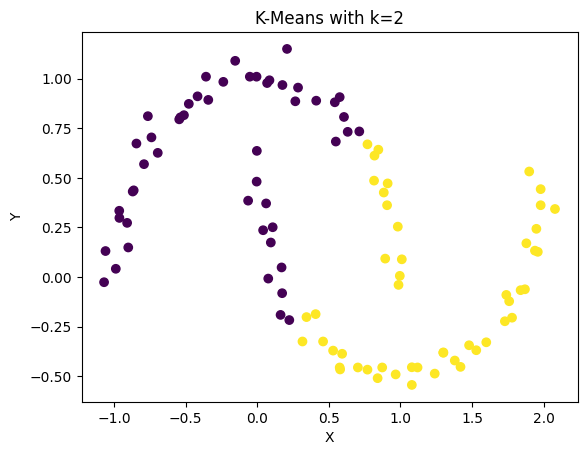

In [6]:
kmeans = KMeans(2, init = 'random')
kmeans.fit(df_dbscan)
clusters = kmeans.labels_

plt.scatter(x = df_dbscan['x'], y = df_dbscan['y'], c = clusters)
plt.title('K-Means with k=2')
plt.xlabel('X')
plt.ylabel('Y');

K-means clustering uses centroids and a distance measure to cluster points, so clusters will take on a circular shape. In this case, the data is clustered in curved lines rather than circles, so the k-means algorithm is not ideal for this data and generates many misclassifications. 

## Function to implement range query 

This function takes in a dataframe containing all of the points in our data set (df_data), the point (Q) represented by it's index in the data frame (q_index), and a floating point value that indicates the radius from point Q to search for neighbors (eps). It will return the slice of df_data containing all the points within eps distance of Q, including Q. 

The distance measure used here will be set as Euclidean distance. 

In [7]:
def range_query( df_data, q_index, eps ):
    p = df_data.iloc[q_index]
    dist = np.linalg.norm((df_data-p), axis = 1)
    return df_data[dist <  eps]

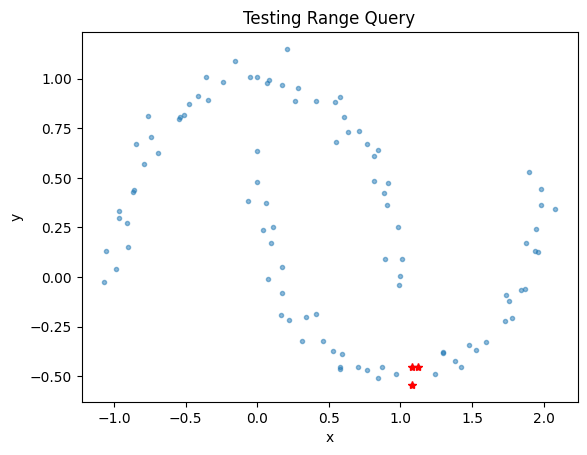

In [8]:
df_n = range_query( df_dbscan, 0, 0.1 )
plt.plot( df_dbscan['x'], df_dbscan['y'], '.', alpha = 0.5 )
plt.plot( df_n['x'], df_n['y'], 'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Testing Range Query')
plt.show()

## Function to implement DBSCAN 

This function accepts a dataframe of points to be clustered (df_data), a floating point that defines the radius of search (eps), and an integer that defines the minimum points required for a cluster (minPts). It returns a series of cluster assignments of the same length as df_data. 

If the data is classified as noise, the cluster assignment is 0, and all of the clusters will have a label of 1-k, were k is derived in the function and represents the total number of clusters found. 

The distance measure used will be set as Euclidean distance. 

Parameters: 
- eps = 0.23 
- minPts = 6

In [9]:
def dbscan( df_data, eps, min_pts ):
        
    NOISE_LABEL = 0
    labels = [None] * len(df_data)                    # cluster labels list
    C = 0                                             # cluster counter 
    
    for P in df_data.iterrows():
        idx = P[0]
        series = P[1]
        
        if labels[idx] is not None:                   # previously processed 
            continue
            
        N = range_query(df_data, idx, eps)            # find neighbors 
        if len(N) < min_pts:                          # density check 
            labels[idx] = NOISE_LABEL                 # label as noise
            continue

        C += 1                                        # next cluster label
        labels[idx] = C                               # label initial point
        S = N.drop(idx).index.tolist()                # neighbors to expand (indexes)

        for Q_idx in S:                               # process every seed point 
            
            if labels[Q_idx] == NOISE_LABEL:          # change noise to border point
                labels[Q_idx] = C   
            if labels[Q_idx] is not None:             # previously processed 
                continue
            labels[Q_idx] = C                         # label neighbor 
            
            N = range_query(df_data, Q_idx, eps)      # find neighbors
            if len(N) >= min_pts:                     # density check 
                N_lst = N.drop(Q_idx).index.tolist()
                S.extend(N_lst)                       # add new neighbors to seed set 
    
    return pd.Series(labels)

In [10]:
# implement DBSCAN on test data 
s_cluster_assignment = dbscan( df_dbscan, 0.23, 6)
s_cluster_assignment.value_counts()

1    49
2    48
0     3
dtype: int64

## Results of generated DBSCAN clustering 

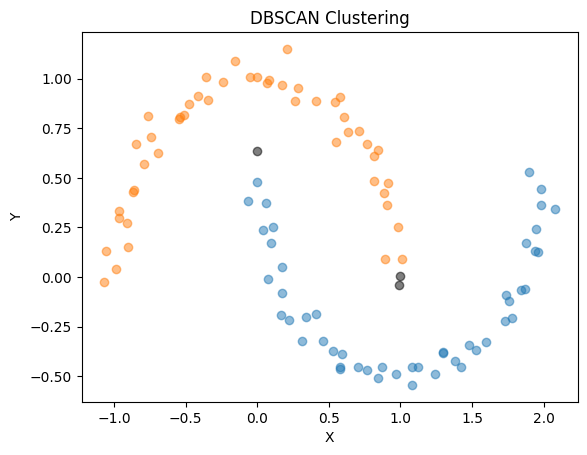

In [11]:
for cluster in s_cluster_assignment.index:
    
    if cluster == 0:
        plt.scatter(df_dbscan['x'][s_cluster_assignment == cluster], 
                    df_dbscan['y'][s_cluster_assignment == cluster], 
                    alpha = 0.5, 
                    color = 'black')
    else:
        plt.scatter(df_dbscan['x'][s_cluster_assignment == cluster], 
                    df_dbscan['y'][s_cluster_assignment == cluster], 
                    alpha = 0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering');

## Compare the results to the scikit-learn library 

In [19]:
dbscan = DBSCAN(eps=0.23, min_samples=6)
assignment = pd.Series(dbscan.fit_predict(df_dbscan))
assignment.value_counts()

 0    49
 1    48
-1     3
dtype: int64

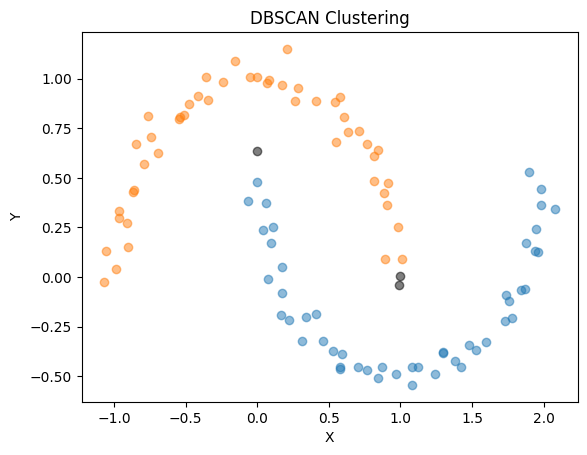

In [20]:
for cluster in [0,1,-1]:
    
    if cluster == -1: # noise points 
        plt.scatter(df_dbscan['x'][assignment == cluster], 
                    df_dbscan['y'][assignment == cluster], 
                    alpha = 0.5, 
                    color = 'black')
    else:
        plt.scatter(df_dbscan['x'][assignment == cluster], 
                    df_dbscan['y'][assignment == cluster], 
                    alpha = 0.5)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('DBSCAN Clustering');

## Results 

Both implementations produced the same results: 2 clusters and 3 noise points. Based on this, I would say the manual and automatic DBSCAN algorithms performed with equal efficacy.